<div style="background-color:#FCE205; padding:10px; border-radius:5px; color:black; font-weight:bold;">
    <h2>Predicting Bee Colony Loss for US states</h2>
</div>

As observed in notebook 3 EDA, percent loss of bee colonies differs strongly across quarters and is affected by different features in different states.

Moreover, time series forecasting require the timestamps to be unique. This dataset however has the same daterange per state.

Therefore, a subset of data is taken for a given state to obtain unique timestamps and models are built per state.

**Recommended**: Run the full notebook first, results will be shown for 'Ohio'. A different state can be given as input.

At the end of the notebook, functions are available to compare outputs for different states at once.

**Note**: The remaining data available per state is very limited. Hence the predictive power of the models will be small.

In [1]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns 
import os
import sys

from datetime import datetime, date

from pmdarima import auto_arima

from statsmodels.tsa.api import VAR
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

from xgboost import XGBRegressor

import warnings # Supress warnings 
warnings.filterwarnings('ignore')

from colorama import Fore

import xgboost as xgb

sys.path.append(os.path.abspath('../utils'))
from tinne_utils import create_quarterly_index, subset_by_state, adf_test, set_bee_style

set_bee_style()

In [2]:
# set working directory
ITM_DIR = os.path.join(os.getcwd(), '../data/cleaned')

In [3]:
# read in data
bees = pd.read_csv(os.path.join(ITM_DIR, 'bees_clean_imputed.csv'))
bees = bees.drop('state_code', axis = 1)

In [4]:
bees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436 entries, 0 to 1435
Data columns (total 51 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   state                      1436 non-null   object 
 1   latitude                   1436 non-null   float64
 2   longitude                  1436 non-null   float64
 3   quarter                    1436 non-null   int64  
 4   temperature_2m_mean        1436 non-null   float64
 5   temperature_2m_sum         1436 non-null   float64
 6   relative_humidity_2m_mean  1436 non-null   float64
 7   relative_humidity_2m_sum   1436 non-null   float64
 8   wind_speed_10m_max         1436 non-null   float64
 9   temperature_2m_max         1436 non-null   float64
 10  relative_humidity_2m_max   1436 non-null   float64
 11  temperature_2m_min         1436 non-null   float64
 12  relative_humidity_2m_min   1436 non-null   float64
 13  precipitation_hours_sum    1436 non-null   float

<div style="background-color:#FCE205; padding:10px; border-radius:5px; color:black; font-weight:bold;">
    <h3>Set State for Model Selection</h3>
</div>

A subset of data is taken for a given state to obtain unique timestamps. Forecasting models are built per state.

**Note**: The remaining data available per state is very limited. Hence the predictive power of the models will be small.

In [4]:
state = 'Ohio'
state_bees = subset_by_state(bees,state)
state_bees = create_quarterly_index(state_bees)

In [6]:
state_bees

,state,latitude,longitude,quarter,temperature_2m_mean,temperature_2m_sum,relative_humidity_2m_mean,relative_humidity_2m_sum,wind_speed_10m_max,temperature_2m_max,...,percent_lost,added_colonies,renovated_colonies,percent_renovated,varroa_mites,other_pests_and_parasites,diseases,pesticides,other_or_unknown,date
33,Ohio,40.388783,-82.764915,1,-4.120917,-370.882506,71.752582,6457.732372,37.008278,18.524500,...,48.0000,5000.000000,3300.000000,15.000000,10.70000,1.600000,1.000000,3.000000,17.800000,2015-01-01
49,Ohio,40.388783,-82.764915,2,16.084390,1463.679447,72.432189,6591.329241,40.877045,30.274500,...,11.0000,10000.000000,6000.000000,32.000000,15.80000,4.100000,3.000000,11.900000,29.000000,2015-04-01
112,Ohio,40.388783,-82.764915,3,20.747167,1908.739380,71.829952,6608.355581,27.804028,30.524500,...,8.0000,2300.000000,880.000000,4.000000,30.70000,8.000000,0.600000,23.400000,1.700000,2015-07-01
168,Ohio,40.388783,-82.764915,4,8.742503,804.310239,72.493653,6669.416112,39.284560,23.074500,...,13.0000,200.000000,140.000000,1.000000,36.30000,8.800000,2.000000,7.300000,14.500000,2015-10-01
224,Ohio,40.388783,-82.764915,1,1.368662,124.548242,69.328429,6308.887028,36.575005,21.724499,...,18.0000,760.000000,50.000000,0.000000,41.60000,4.300000,0.200000,1.300000,10.200000,2016-01-01
244,Ohio,40.388783,-82.764915,2,15.115617,1375.521141,68.018907,6189.720501,38.413870,30.924500,...,10.0000,6000.000000,1100.000000,7.000000,10.60000,2.200000,0.600000,18.300000,2.900000,2016-04-01
290,Ohio,40.388783,-82.764915,3,22.652217,2084.003930,72.302978,6651.873968,28.820242,31.924498,...,8.0000,980.000000,630.000000,3.000000,60.60000,10.600000,2.300000,2.900000,3.600000,2016-07-01
339,Ohio,40.388783,-82.764915,4,6.677625,614.341477,71.952698,6619.648231,34.862427,25.874498,...,11.0000,20.000000,140.000000,1.000000,42.00000,18.100000,0.800000,4.200000,11.200000,2016-10-01
373,Ohio,40.388783,-82.764915,1,3.012607,271.134594,69.900355,6291.031963,41.835964,21.432999,...,25.0000,1300.000000,530.000000,3.000000,25.80000,11.600000,0.600000,0.100000,16.500000,2017-01-01
428,Ohio,40.388783,-82.764915,2,16.094538,1464.602964,69.647167,6337.892219,38.105620,29.633000,...,7.0000,7000.000000,2500.000000,17.000000,45.50000,6.400000,6.200000,10.400000,16.600000,2017-04-01


<div style="background-color:#FCE205; padding:10px; border-radius:5px; color:black; font-weight:bold;">
    <h3>Time Series Sanity Check</h3>
</div>

The data should be in chronological order and the timestamps should be equidistant in time series. 

The chronological order can be achieved by sorting the dataframe by the timestamps.

 Equidisant timestamps indicates constant time intervals. To check this, the difference between each timestamp is taken. 

In [6]:
state_bees = state_bees.sort_values(by='date')

state_bees['delta'] = state_bees['date'] - state_bees['date'].shift(1)

state_bees[['date', 'delta']]

state_bees['delta'].value_counts()

delta
92 days    15
91 days    10
90 days     6
Name: count, dtype: int64

Quarter lengths may vary depending on month length and leap years.

The results confirm the time interval is one quarter (90-92 days).

In [7]:
# drop delta column
state_bees = state_bees.drop('delta', axis = 1)

<div style="background-color:#FCE205; padding:10px; border-radius:5px; color:black; font-weight:bold;">
    <h3>Time Series Evaluation for Model Selection</h3>
</div>

Some time series models, assume that the underlying data is stationary. 

A time series is stationary if its key statistical properties do not change over time:

**Constant mean**

**Constant variance**

**Constant autocovariance (dependence between values at different lags stays the same)**

Stationarity is checked visually and statistically by the Augmented Dickey Fuller test

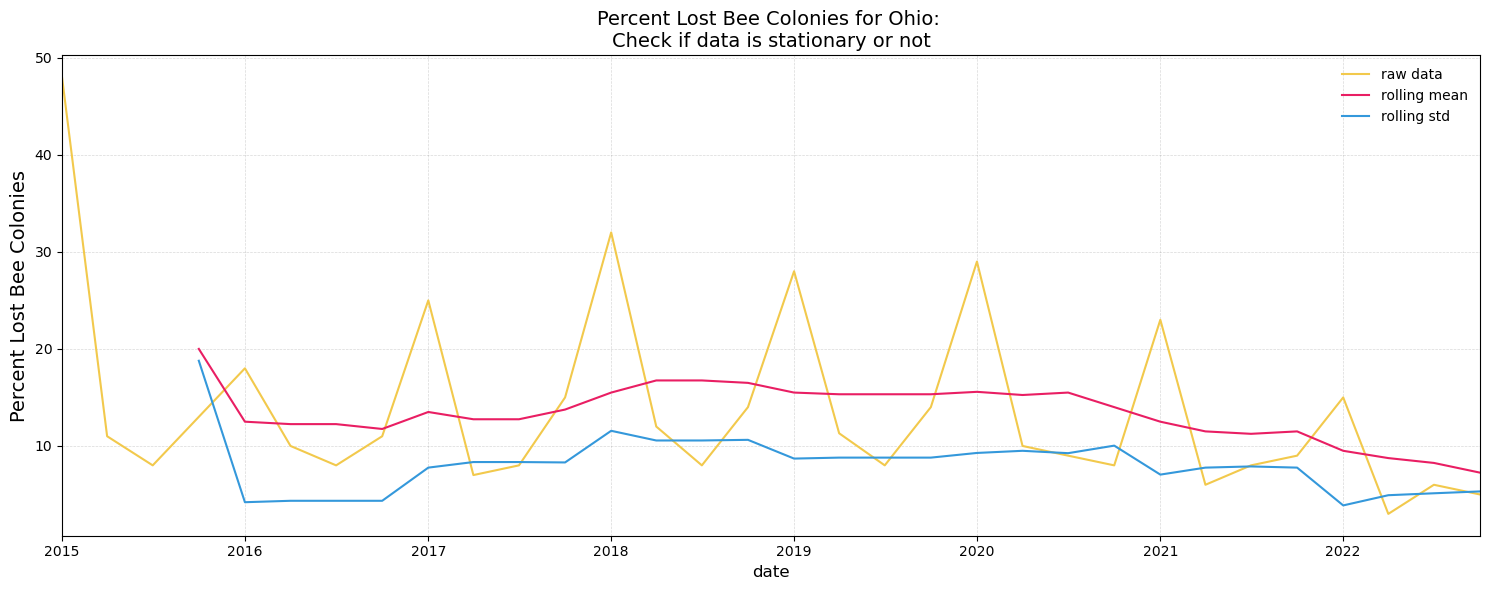

In [8]:
# Visual check of the data
rolling_window = 4

fig, ax = plt.subplots(figsize=(15, 6))

sns.lineplot(x=state_bees['date'], y=state_bees['percent_lost'], ax=ax, label='raw data')
sns.lineplot(x=state_bees['date'], y=state_bees['percent_lost'].rolling(rolling_window).mean(), ax=ax, label='rolling mean')
sns.lineplot(x=state_bees['date'], y=state_bees['percent_lost'].rolling(rolling_window).std(), ax=ax,label='rolling std')

ax.set_title(f'Percent Lost Bee Colonies for {state}: \nCheck if data is stationary or not', fontsize=14)
ax.set_ylabel('Percent Lost Bee Colonies', fontsize=14)
ax.set_xlim([date(2015, 1, 1), date(2022, 10, 1)])

# Disable scientific notation on y-axis
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
ax.ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()

In [108]:
# Statitical test for stationarity
adf_test(state_bees['percent_lost'], state)

ADF test statistic     -6.667008
p-value                      0.0
# lags used                  0.0
# observations              31.0
critical value (1%)    -3.661429
critical value (5%)    -2.960525
critical value (10%)   -2.619319
stationary                  True
dtype: object

In [109]:
stationarity_flags = []

# Loop through each state
for state in bees['state'].unique():
    series = bees[bees['state'] == state]['percent_lost']
    result = adf_test(series, state)
    stationarity_flags.append(result['stationary'])

# Convert to Series for easy analysis
flags_series = pd.Series(stationarity_flags)

# Compute ratio
true_ratio = flags_series.mean()  # This gives the proportion of True values
false_ratio = 1 - true_ratio

print(f"Stationary (True) ratio: {true_ratio:.2f}")
print(f"Non-stationary (False) ratio: {false_ratio:.2f}")

Stationary (True) ratio: 0.60
Non-stationary (False) ratio: 0.40


Looks like 60% of the states percent lost data is stationary whereas 40% is not.

Time series decomposition may provide additional information.

<div style="background-color:#FCE205; padding:10px; border-radius:5px; color:black; font-weight:bold;">
    <h3>Time Series Decomposition</h3>
</div>

Time series are often a combination of trend, seasonality and noise.

- **Trend**: The overall increasing or decreasing value
- **Seasonality**: The repeating short-term cycle
- **Noise**: The random variation

Decomposition allows for for better understanding problems during analysis and forecasting

In [9]:
decomp = seasonal_decompose(state_bees['percent_lost'], period=4, model='additive', extrapolate_trend='freq')
state_bees[f"{'percent_lost'}_trend"] = decomp.trend
state_bees[f"{'percent_lost'}_seasonal"] = decomp.seasonal

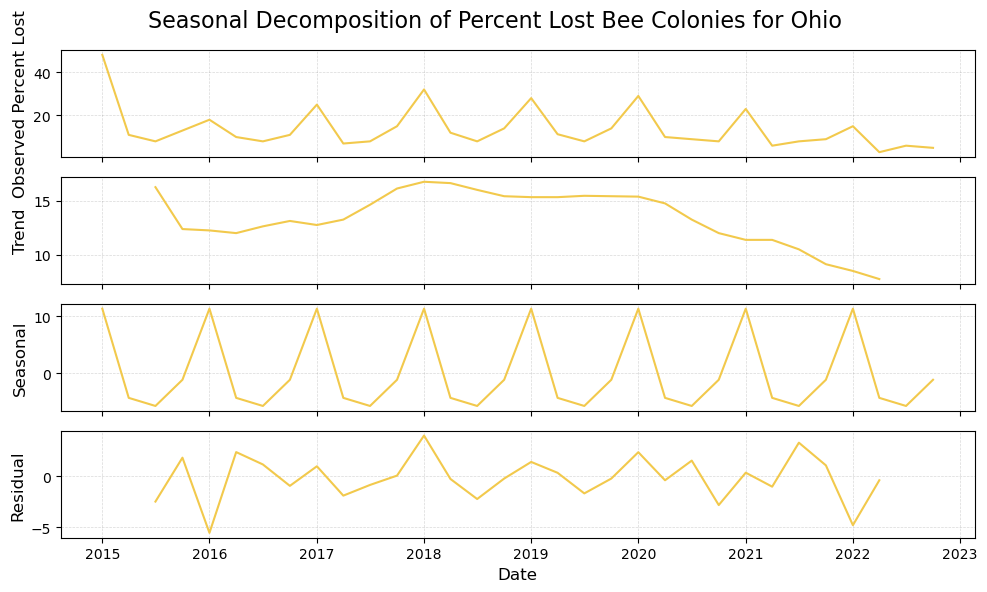

In [11]:
# Sort and set date index
state_bees = state_bees.sort_values('date')
state_bees_indexed = state_bees.set_index('date')

# Decompose
result = seasonal_decompose(state_bees_indexed['percent_lost'], model='additive', period=4)

# Manual plotting with renamed y-axis for 'observed'
fig, axs = plt.subplots(4, 1, figsize=(10, 6), sharex=True)

axs[0].plot(result.observed)
axs[0].set_ylabel('Observed Percent Lost')

axs[1].plot(result.trend, label='Trend')
axs[1].set_ylabel('Trend')

axs[2].plot(result.seasonal, label='Seasonal')
axs[2].set_ylabel('Seasonal')

axs[3].plot(result.resid, label='Residual')
axs[3].set_ylabel('Residual')
axs[3].set_xlabel('Date')

fig.suptitle(f'Seasonal Decomposition of Percent Lost Bee Colonies for {state}', fontsize=16)
plt.tight_layout()
plt.show()

<div
  style="
    background-color: #FCE205;
    padding: 10px 20px;      /* you can tweak horizontal padding */
    border-radius: 5px;
    color: black;
    font-weight: bold;
    height: 60px;            /* adjust as needed */
    line-height: 50px;
  "
>
  <h3 style="margin: 0;">Model Evaluation on Univariate Time series</h3>
</div>

<div
  style="
    background-color: #985b10;
    color: white;
    font-weight: bold;
    height: 50px;
    line-height: 50px;
    border-radius: 5px;
    padding: 0 10px;
  "
>
  <h5 style="margin: 0; display: inline-block; vertical-align: middle;">
    Model Evaluation on Univariate Time series
  </h5>
</div>


<div style="line-height:1.5">
Univariate time-series forecasting focuses on predicting future values of a single target variable using nothing but its own historical observations. 

By analyzing patterns such as trends, seasonality, and autocorrelation in past data, models like ARIMA, exponential smoothing, and modern machine-learning approaches can extrapolate into the future.
 </div>

<div
  style="
    background-color: #fffad5;
    color: black;
    font-weight: bold;
    height: 50px;
    line-height: 50px;
    border-radius: 5px;
    padding: 0 10px;
  "
>
  <h8 style="margin: 0; display: inline-block; vertical-align: middle;">
    Static method for univariate analysis
  </h8>
</div>

<div style="line-height:1.5">
In static forecasting our models only ever sees the “past” once and all future forecasts are extrapolations from that one fit.
 </div>

In [13]:
def compare_univariate_static(
    df: pd.DataFrame,
    date_col: str,
    target_col: str,
    n_test: int = 8,
    seasonal_m: int = 4,
    lags: list[int] = [1, 4]
) -> pd.DataFrame:
    """
    Static multi-step forecasts on a univariate series without pmdarima:
      - Holt–Winters
      - SARIMAX(1,1,1)x(1,1,1)
      - RandomForest on lag features
      - XGBoost on lag features

    Plots full actual series plus each model's n_test-step forecast,
    returns DataFrame of RMSE/MAE for each model.
    """
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df.set_index(date_col, inplace=True)
    df.sort_index(inplace=True)
    series = df[target_col]

    # split
    train = series.iloc[:-n_test]
    test  = series.iloc[-n_test:]

    # 1) Holt–Winters
    hwes = ExponentialSmoothing(
        train, trend='add', seasonal='add', seasonal_periods=seasonal_m
    ).fit()
    hwes_preds = pd.Series(hwes.forecast(n_test), index=test.index)

    # 2) SARIMAX(1,1,1)x(1,1,1,seasonal_m)
    sarimax = SARIMAX(
        train,
        order=(1,1,1),
        seasonal_order=(1,1,1,seasonal_m),
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)
    sarimax_preds = pd.Series(
        sarimax.forecast(steps=n_test),
        index=test.index
    )

    # 3) lag features
    df_lag = pd.DataFrame({'y': series})
    for lag in lags:
        df_lag[f'lag_{lag}'] = df_lag['y'].shift(lag)
    df_lag.dropna(inplace=True)

    ml_train = df_lag.iloc[:-n_test]
    ml_test  = df_lag.iloc[-n_test:]
    X_train, y_train = ml_train[[f'lag_{lag}' for lag in lags]], ml_train['y']
    X_test,  y_test  = ml_test [[f'lag_{lag}' for lag in lags]], ml_test['y']

    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    rf_preds = pd.Series(rf.predict(X_test), index=y_test.index)

    xgb = XGBRegressor(
        n_estimators=100, random_state=42,
        use_label_encoder=False, eval_metric='rmse'
    )
    xgb.fit(X_train, y_train)
    xgb_preds = pd.Series(xgb.predict(X_test), index=y_test.index)

    # metrics
    def compute_metrics(y_true, y_pred):
        mask = (~y_true.isna()) & (~y_pred.isna())
        if not mask.any():
            return np.nan, np.nan
        return (
            np.sqrt(mean_squared_error(y_true[mask], y_pred[mask])),
            mean_absolute_error(y_true[mask], y_pred[mask])
        )

    models = ['HWES', 'SARIMAX', 'RF (lags)', 'XGB (lags)']
    preds_list = [hwes_preds, sarimax_preds, rf_preds, xgb_preds]
    metrics = pd.DataFrame([
        (m, *compute_metrics(test, p))
        for m,p in zip(models, preds_list)
    ], columns=['Model','RMSE','MAE'])

    # plot
    actual_full = series
    df_fore = pd.DataFrame({
        'HWES':      hwes_preds,
        'SARIMAX':   sarimax_preds,
        'RF (lags)': rf_preds,
        'XGB (lags)':xgb_preds
    })
    df_plot = pd.concat([actual_full.rename('Actual'), df_fore], axis=1)

    fig, ax = plt.subplots(figsize=(12,6))
    df_plot['Actual'].plot(ax=ax, color='black', lw=2, label='Actual')
    df_plot[['HWES','SARIMAX','RF (lags)','XGB (lags)']].plot(
        ax=ax, linestyle='--', marker='o', alpha=0.8
    )
    split_date = train.index[-1]
    ax.axvline(split_date, color='gray', linestyle=':', label='Train/Test split')
    ax.set_title(f'Full Actual Series + {n_test}-Step Forecasts by Model')
    ax.set_xlabel('Date')
    ax.set_ylabel(target_col)
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()

    return metrics


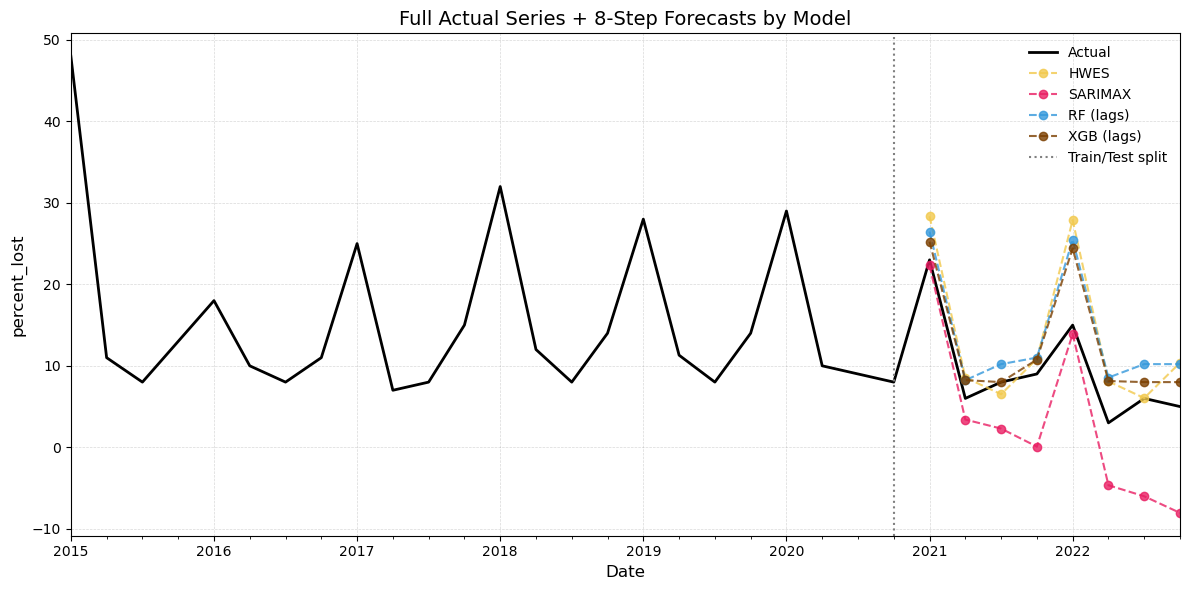

,Model,RMSE,MAE
0,HWES,5.716515,4.329202
1,SARIMAX,7.854118,6.462054
2,RF (lags),5.137397,4.420372
3,XGB (lags),4.199480,3.223584


In [14]:
compare_univariate_static(
    df=state_bees,
    date_col='date',
    target_col='percent_lost',
    n_test=8,
    seasonal_m=4,
    lags=[1, 4]
)

<div
  style="
    background-color: #fffad5;
    color: black;
    font-weight: bold;
    height: 50px;
    line-height: 50px;
    border-radius: 5px;
    padding: 0 10px;
  "
>
  <h7 style="margin: 0; display: inline-block; vertical-align: middle;">
    Walk forward method univariate analysis
  </h7>
</div>

<div style="line-height:1.5">
Walk-forward (rolling) forecasting continuously retrains or updates the models as each new observation becomes available, ensuring that the predictions always leverage the most recent data and adapt to evolving patterns.

 </div>

In [23]:
def evaluate_and_plot_walkforward(
    df: pd.DataFrame,
    date_col: str,
    target_col: str,
    n_test: int = 8,
    seasonal_m: int = 4,
    lags: list[int] = [1, 4]
) -> pd.DataFrame:
    """
    One-step walk-forward on a univariate series (with a datetime column),
    computing cumulative RMSE/MAE and plotting them with quarter labels.
    """
    # 1) Prepare series with DatetimeIndex
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    series = df.set_index(date_col)[target_col].sort_index()

    # 2) Split train/test
    train = series.iloc[:-n_test]
    test  = series.iloc[-n_test:]

    # 3) Generic walk-forward
    def walk_forward(model_builder, forecast_fn):
        history = train.copy()
        preds   = []
        for t in range(n_test):
            m  = model_builder(history)
            fc = forecast_fn(m, history)
            preds.append(fc)
            history.loc[test.index[t]] = test.iloc[t]
        return np.array(preds)

    # 4) Model builders & fns
    def build_hwes(y):
        return ExponentialSmoothing(
            y, trend='add', seasonal='add',
            seasonal_periods=seasonal_m
        ).fit()
    def f_hwes(m, h): return m.forecast(1).iloc[0]

    def build_ari(y):
        return auto_arima(
            y, seasonal=True, m=seasonal_m,
            stepwise=True, trace=False,
            error_action='ignore'
        )
    def f_ari(m, h): return np.asarray(m.predict(1)).ravel()[0]

    def build_rf(h):
        df_l = pd.DataFrame({'y': h})
        for lag in lags:
            df_l[f'lag_{lag}'] = df_l['y'].shift(lag)
        df_l.dropna(inplace=True)
        X = df_l[[f'lag_{lag}' for lag in lags]]
        y = df_l['y']
        rf = RandomForestRegressor(n_estimators=100, random_state=42)
        rf.fit(X, y)
        return rf
    def f_rf(m, h):
        feat = {f'lag_{lag}': h.iloc[-lag] for lag in lags}
        return m.predict(pd.DataFrame([feat]))[0]

    def build_xgb(h):
        df_l = pd.DataFrame({'y': h})
        for lag in lags:
            df_l[f'lag_{lag}'] = df_l['y'].shift(lag)
        df_l.dropna(inplace=True)
        X = df_l[[f'lag_{lag}' for lag in lags]]
        y = df_l['y']
        xgb = XGBRegressor(
            n_estimators=100, random_state=42,
            use_label_encoder=False, eval_metric='rmse'
        )
        xgb.fit(X, y)
        return xgb
    def f_xgb(m, h):
        feat = {f'lag_{lag}': h.iloc[-lag] for lag in lags}
        return m.predict(pd.DataFrame([feat]))[0]

    # 5) Run forecasts
    preds_hwes  = walk_forward(build_hwes,  f_hwes)
    preds_ari   = walk_forward(build_ari,   f_ari)
    preds_rf    = walk_forward(build_rf,    f_rf)
    preds_xgb   = walk_forward(build_xgb,   f_xgb)

    # 6) Overall metrics
    metrics = pd.DataFrame({
        'Model': ['HWES','AutoARIMA','RF (lags)','XGB (lags)'],
        'RMSE': [
            np.sqrt(mean_squared_error(test, preds_hwes)),
            np.sqrt(mean_squared_error(test, preds_ari)),
            np.sqrt(mean_squared_error(test, preds_rf)),
            np.sqrt(mean_squared_error(test, preds_xgb))
        ],
        'MAE': [
            mean_absolute_error(test, preds_hwes),
            mean_absolute_error(test, preds_ari),
            mean_absolute_error(test, preds_rf),
            mean_absolute_error(test, preds_xgb)
        ]
    })

    # 7) Build cumulative error DataFrames (indexed by quarter dates)
    idx = test.index
    cum_rmse = pd.DataFrame({
        'HWES':      [np.sqrt(mean_squared_error(test.values[:k], preds_hwes[:k])) for k in range(1, n_test+1)],
        'AutoARIMA': [np.sqrt(mean_squared_error(test.values[:k], preds_ari[:k])) for k in range(1, n_test+1)],
        'RF (lags)': [np.sqrt(mean_squared_error(test.values[:k], preds_rf[:k])) for k in range(1, n_test+1)],
        'XGB (lags)':[np.sqrt(mean_squared_error(test.values[:k], preds_xgb[:k])) for k in range(1, n_test+1)]
    }, index=idx)

    cum_mae = pd.DataFrame({
        'HWES':      [mean_absolute_error(test.values[:k], preds_hwes[:k]) for k in range(1, n_test+1)],
        'AutoARIMA': [mean_absolute_error(test.values[:k], preds_ari[:k]) for k in range(1, n_test+1)],
        'RF (lags)': [mean_absolute_error(test.values[:k], preds_rf[:k]) for k in range(1, n_test+1)],
        'XGB (lags)':[mean_absolute_error(test.values[:k], preds_xgb[:k]) for k in range(1, n_test+1)]
    }, index=idx)

    quarters = [f"{d.year}Q{d.quarter}" for d in idx]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4), sharex=True)
    
    cum_rmse.plot(ax=ax1, marker='o')
    ax1.set_title('Cumulative RMSE by Predicted Quarter')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('RMSE')
    ax1.grid(True)
    # force our custom quarter labels
    ax1.set_xticks(idx)
    ax1.set_xticklabels(quarters, rotation=90, ha='center')
    
    cum_mae.plot(ax=ax2, marker='o')
    ax2.set_title('Cumulative MAE by Predicted Quarter')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('MAE')
    ax2.grid(True)
    # same for the second subplot
    ax2.set_xticks(idx)
    ax2.set_xticklabels(quarters, rotation=90, ha='center')
    
    plt.tight_layout()
    plt.show()

    return metrics


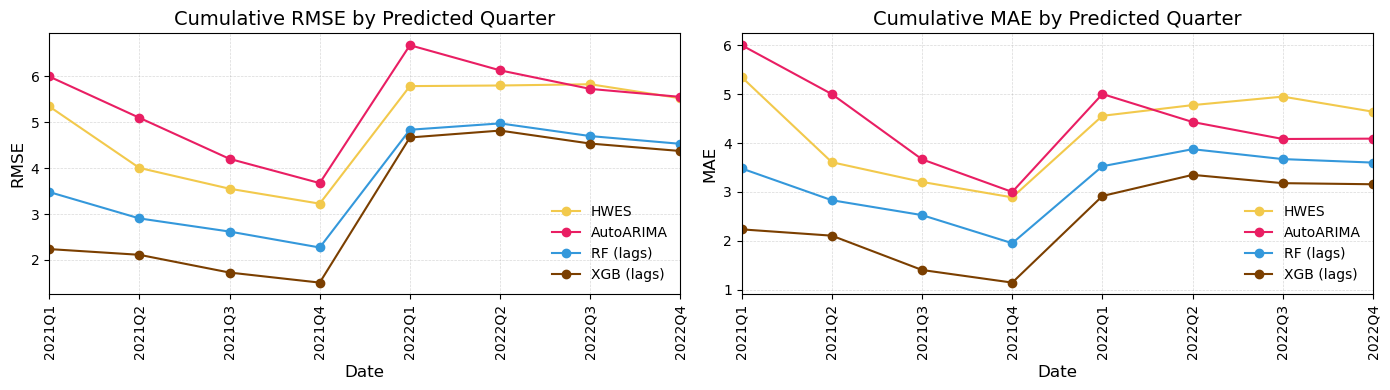

        Model      RMSE       MAE
0        HWES  5.524030  4.640361
1   AutoARIMA  5.554806  4.089583
2   RF (lags)  4.530796  3.600143
3  XGB (lags)  4.374013  3.157178


In [24]:
metrics = evaluate_and_plot_walkforward(
    df=state_bees,
    date_col='date',
    target_col='percent_lost',
    n_test=8,
    seasonal_m=4,
    lags=[1,4]
)
print(metrics)

<div
  style="
    background-color: #985b10;
    color: white;
    font-weight: bold;
    height: 50px;
    line-height: 50px;
    border-radius: 5px;
    padding: 0 10px;
  "
>
  <h5 style="margin: 0; display: inline-block; vertical-align: middle;">
    Model Evaluation on Multivariate Time series
  </h5>
</div>

Multivariate forecasting lets us incorporate additional features (exogenous features, e.g. weather, diseases) into models. However, when we roll our model forward to make predictions, we typically no longer have “future” values of those features. To address this, we derive lagged versions of every input (target and exogenous) from the historical data (e.g. t-1, t-4, etc.). We will train Random Forest and XGBoost models on those lagged features and when forecasting, we again supply just those same lagged values. This ensures our predictions rely solely on information that would actually have been available at forecast time.

<div
  style="
    background-color: #fffad5;
    color: black;
    font-weight: bold;
    height: 50px;
    line-height: 50px;
    border-radius: 5px;
    padding: 0 10px;
  "
>
  <h7 style="margin: 0; display: inline-block; vertical-align: middle;">
    Static method for multivariate analysis
  </h7>
</div>

In [251]:
state_bees.columns

Index(['state', 'latitude', 'longitude', 'quarter', 'temperature_2m_meanmean',
       'temperature_2m_meansum', 'relative_humidity_2m_meanmean',
       'relative_humidity_2m_meansum', 'wind_speed_10m_maxmax',
       'temperature_2m_maxmax', 'relative_humidity_2m_maxmax',
       'temperature_2m_minmin', 'relative_humidity_2m_minmin',
       'precipitation_hours_sum', 'moderate_drizzle_sum', 'moderate_rain_sum',
       'light_rain_sum', 'heavy_rain_sum', 'overcast_sum', 'partly_cloudy_sum',
       'clear_sky_sum', 'light_drizzle_sum', 'mainly_clear_sum',
       'heavy_drizzle_sum', 'light_snow_sum', 'heavy_snow_sum',
       'moderate_snow_sum', 'year', 'D0_mean', 'D1_mean', 'D2_mean', 'D3_mean',
       'D4_mean', 'D0_max', 'D1_max', 'D2_max', 'D3_max', 'D4_max',
       'num_colonies', 'max_colonies', 'lost_colonies', 'percent_lost',
       'added_colonies', 'renovated_colonies', 'percent_renovated',
       'varroa_mites', 'other_pests_and_parasites', 'diseases', 'pesticides',
       'oth

In [25]:
def compare_multivariate_models(
    df: pd.DataFrame,
    date_col: str,
    target_col: str,
    exog_cols: list,
    n_test: int = 8,
    seasonal_m: int = 4,
    lags: list = [1, 4]
) -> pd.DataFrame:
    """
    Fits and compares multivariate forecasting models on a single series:
      - ARIMAX
      - VAR
      - RandomForest on lag features
      - XGBoost on lag features

    Parameters
    ----------
    df : DataFrame
        Must contain a date column, a target series, and exogenous columns.
    date_col : str
        Name of the datetime column.
    target_col : str
        Name of the series to forecast.
    exog_cols : list of str
        Names of exogenous covariate columns.
    n_test : int
        Number of periods to hold out at the end for testing.
    seasonal_m : int
        Seasonal period (e.g. 4 for quarterly data).
    lags : list of int
        Lags to include for ML models.

    Returns
    -------
    metrics : DataFrame
        RMSE and MAE for each model.
    """
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df.set_index(date_col, inplace=True)
    df.sort_index(inplace=True)

    series   = df[target_col]
    exog     = df[exog_cols]
    train_y  = series.iloc[:-n_test]
    test_y   = series.iloc[-n_test:]
    train_ex = exog.iloc[:-n_test]
    test_ex  = exog.iloc[-n_test:]

    # ARIMAX
    arimax = auto_arima(
        train_y, exogenous=train_ex,
        seasonal=True, m=seasonal_m,
        stepwise=True, trace=False,
        error_action='ignore'
    )
    arimax_preds = pd.Series(
        arimax.predict(n_periods=n_test, exogenous=test_ex),
        index=test_y.index
    )

    # VAR with safe lag selection
    df_var    = pd.concat([series, exog], axis=1)
    train_var = df_var.iloc[:-n_test]
    test_var  = df_var.iloc[-n_test:]
    var_model = VAR(train_var)
    k, N = train_var.shape[1], train_var.shape[0]
    try:
        var_fit = var_model.fit(ic='aic', maxlags=seasonal_m)
    except ValueError:
        maxlags_safe = max(1, N // (k * 5))
        var_fit = var_model.fit(maxlags=maxlags_safe)
    var_fc = var_fit.forecast(train_var.values[-var_fit.k_ar:], steps=n_test)
    var_preds = pd.Series(
        var_fc[:, df_var.columns.get_loc(target_col)],
        index=test_y.index
    )

    # ML on lagged features
    df_ml = pd.concat([series.rename('y'), exog], axis=1)
    for col in df_ml.columns:
        for lag in lags:
            df_ml[f'{col}_lag_{lag}'] = df_ml[col].shift(lag)
    df_ml.dropna(inplace=True)
    ml_train = df_ml.iloc[:-n_test]
    ml_test  = df_ml.iloc[-n_test:]
    X_train, y_train = ml_train.drop(columns=['y']), ml_train['y']
    X_test,  y_test  = ml_test.drop(columns=['y']), ml_test['y']

    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    rf_preds = pd.Series(rf.predict(X_test), index=y_test.index)

    xgb = XGBRegressor(
        n_estimators=100,
        random_state=42,
        use_label_encoder=False,
        eval_metric='rmse'
    )
    xgb.fit(X_train, y_train)
    xgb_preds = pd.Series(xgb.predict(X_test), index=y_test.index)

    # Compute metrics
    def compute_metrics(y_true, y_pred):
        mask = (~y_true.isna()) & (~y_pred.isna())
        if mask.sum() == 0:
            return np.nan, np.nan
        return (
            np.sqrt(mean_squared_error(y_true[mask], y_pred[mask])),
            mean_absolute_error(      y_true[mask], y_pred[mask])
        )

    metrics = pd.DataFrame([
        ('ARIMAX',    *compute_metrics(test_y,    arimax_preds)),
        ('VAR',       *compute_metrics(test_y,    var_preds)),
        ('RF (lags)', *compute_metrics(y_test,    rf_preds)),
        ('XGB (lags)',*compute_metrics(y_test,    xgb_preds))
    ], columns=['Model','RMSE','MAE'])

    # Plot
    actual_full = df[target_col]
    df_fore = pd.DataFrame({
        'ARIMAX':    arimax_preds,
        'VAR':       var_preds,
        'RF (lags)': rf_preds,
        'XGB (lags)':xgb_preds
    })
    df_plot = pd.concat([actual_full.rename('Actual'), df_fore], axis=1)

    fig, ax = plt.subplots(figsize=(12,6))

    # Plot actuals and forecasts
    df_plot['Actual'].plot(ax=ax, color='black', lw=2, label='Actual')
    df_plot[['ARIMAX','VAR','RF (lags)','XGB (lags)']].plot(
        ax=ax, linestyle='--', marker='o', alpha=0.8
    )
    
    # Vertical split line
    split_date = train_y.index[-1]
    ax.axvline(split_date, color='gray', linestyle=':', label='Train/Test split')
    
    # Titles & labels
    ax.set_title('Multivariate Static Forecasts vs. Actual')
    ax.set_xlabel('Date')
    ax.set_ylabel(target_col)
    
    # Legend & grid
    ax.legend()
    ax.grid(True)
    
    # ---- New: quarterly x-tick formatting ----
    # Build formatted labels from the datetime index
    quarters = [f"{d.year}Q{d.quarter}" for d in df_plot.index]
    
    # Place ticks at each date and assign our labels
    ax.set_xticks(df_plot.index)
    ax.set_xticklabels(quarters, rotation=90, ha='center', fontsize=8)
    
    plt.tight_layout()
    plt.show()

    return metrics


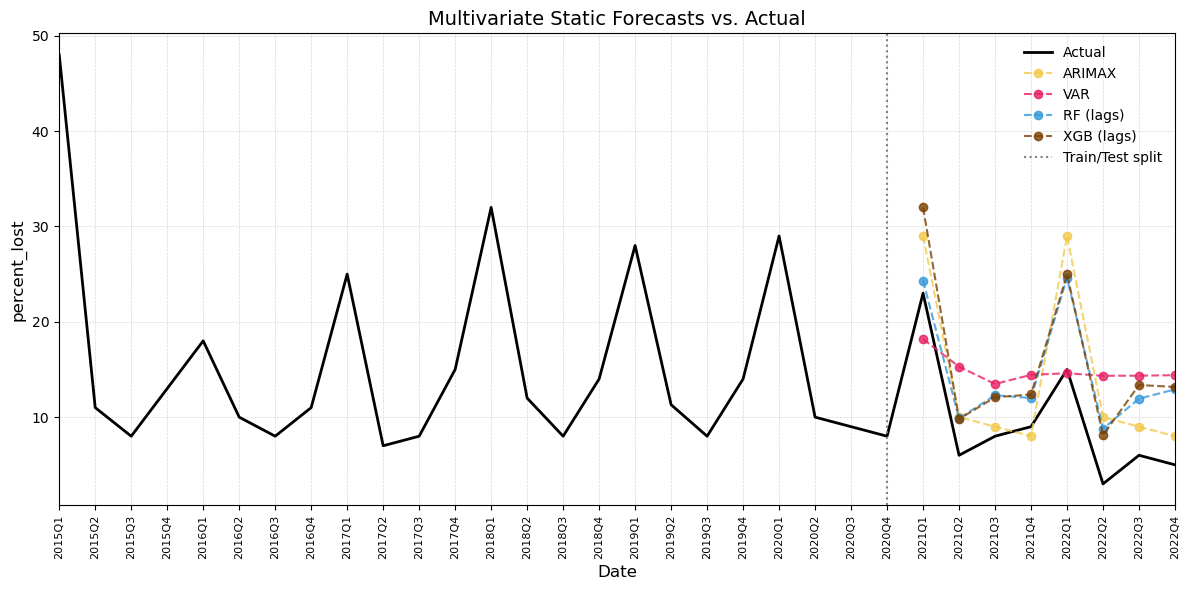

,Model,RMSE,MAE
0,ARIMAX,6.294839,4.875000
1,VAR,7.547799,6.812313
2,RF (lags),5.791592,5.220002
3,XGB (lags),6.801033,6.360681


In [26]:
compare_multivariate_models(
    df=state_bees,
    date_col='date',
    target_col='percent_lost',
    exog_cols=[
        'varroa_mites', 'other_pests_and_parasites', 'diseases', 'pesticides',
        'other_or_unknown'
    ],
    n_test=8,
    seasonal_m=4,
    lags=[1, 4]
)

<div
  style="
    background-color: #fffad5;
    color: black;
    font-weight: bold;
    height: 50px;
    line-height: 50px;
    border-radius: 5px;
    padding: 0 10px;
  "
>
  <h7 style="margin: 0; display: inline-block; vertical-align: middle;">
    Static method for multivariate analysis with variable training windows
  </h7>
</div>

In [34]:
def compare_multivariate_static_windows(
    df: pd.DataFrame,
    date_col: str,
    target_col: str,
    exog_cols: list[str],
    windows: list[int],
    forecast_horizon: int = 4,
    seasonal_m: int = 4,
    lags: list[int] = [1, 4]
) -> pd.DataFrame:
    """
    Compare static multi-step forecasts across different training-window sizes.

    Parameters
    ----------
    df : DataFrame containing date, target, and exogenous columns
    date_col : name of the datetime column
    target_col : name of target series
    exog_cols : list of exogenous variable names
    windows : list of ints, training-window sizes (in quarters)
    forecast_horizon : number of quarters to forecast
    seasonal_m : seasonal period
    lags : list of lag orders for ML models

    Returns
    -------
    metrics_df : DataFrame with columns ['train_quarters','Model','RMSE','MAE']
    and plots RMSE vs train_quarters for each model.
    """
    # prepare DataFrame
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df.set_index(date_col, inplace=True)
    df.sort_index(inplace=True)

    series = df[target_col]
    exog   = df[exog_cols]
    N = len(series)

    # Precompute lag-feature DataFrame for ML once
    df_lag = pd.concat([series.rename('y'), exog], axis=1)
    for col in df_lag.columns:
        for lag in lags:
            df_lag[f'{col}_lag_{lag}'] = df_lag[col].shift(lag)
    df_lag.dropna(inplace=True)

    results = []

    # iterate window sizes
    for w in windows:
        if w + forecast_horizon > N:
            continue

        # define train/test slices for series & exog
        train_y = series.iloc[N - forecast_horizon - w : N - forecast_horizon]
        test_y  = series.iloc[N - forecast_horizon : N]
        train_ex = exog.iloc[N - forecast_horizon - w : N - forecast_horizon]
        test_ex  = exog.iloc[N - forecast_horizon : N]
        idx = test_y.index

        # 1) SARIMAX
        try:
            m_sar = SARIMAX(train_y,
                            order=(1,1,1),
                            seasonal_order=(1,1,1,seasonal_m),
                            exog=train_ex,
                            enforce_stationarity=False,
                            enforce_invertibility=False).fit(disp=False)
            sar_preds = m_sar.get_forecast(steps=forecast_horizon, exog=test_ex).predicted_mean
        except:
            sar_preds = pd.Series([np.nan]*forecast_horizon, index=idx)
        rmse_sar = np.sqrt(mean_squared_error(test_y, sar_preds))
        mae_sar  = mean_absolute_error(test_y, sar_preds)
        results.append((w, 'SARIMAX', rmse_sar, mae_sar))

        # 2) VAR
        df_var = pd.concat([series, exog], axis=1)
        train_var = df_var.iloc[N - forecast_horizon - w : N - forecast_horizon]
        try:
            var_m = VAR(train_var)
            k, Nt = train_var.shape[1], len(train_var)
            try:
                fit_var = var_m.fit(ic='aic', maxlags=seasonal_m)
            except ValueError:
                safe = max(1, Nt//(k*5))
                fit_var = var_m.fit(maxlags=safe)
            fc = fit_var.forecast(train_var.values[-fit_var.k_ar:], steps=forecast_horizon)
            var_preds = pd.Series(fc[:, df_var.columns.get_loc(target_col)], index=idx)
        except:
            var_preds = pd.Series([np.nan]*forecast_horizon, index=idx)
        rmse_var = np.sqrt(mean_squared_error(test_y, var_preds))
        mae_var  = mean_absolute_error(test_y, var_preds)
        results.append((w, 'VAR', rmse_var, mae_var))

        # 3/4) ML on lag features: use precomputed df_lag
        train_ml = df_lag.loc[train_y.index.intersection(df_lag.index)]
        test_ml  = df_lag.loc[test_y.index.intersection(df_lag.index)]

        if len(train_ml) < 1 or len(test_ml) < 1:
            rmse_rf, mae_rf, rmse_xgb, mae_xgb = np.nan, np.nan, np.nan, np.nan
        else:
            X_tr, y_tr = train_ml.drop(columns=['y']), train_ml['y']
            X_te, y_te = test_ml.drop(columns=['y']),  test_ml['y']

            rf = RandomForestRegressor(n_estimators=100, random_state=42)
            rf.fit(X_tr, y_tr)
            rf_preds = pd.Series(rf.predict(X_te), index=test_ml.index)
            rmse_rf = np.sqrt(mean_squared_error(y_te, rf_preds))
            mae_rf  = mean_absolute_error(y_te, rf_preds)

            xgb = XGBRegressor(n_estimators=100, random_state=42,
                               use_label_encoder=False, eval_metric='rmse')
            xgb.fit(X_tr, y_tr)
            xgb_preds = pd.Series(xgb.predict(X_te), index=test_ml.index)
            rmse_xgb = np.sqrt(mean_squared_error(y_te, xgb_preds))
            mae_xgb  = mean_absolute_error(y_te, xgb_preds)

        results.append((w, 'RF', rmse_rf, mae_rf))
        results.append((w, 'XGB', rmse_xgb, mae_xgb))

    # assemble metrics DataFrame
    metrics_df = pd.DataFrame(results, columns=['train_quarters','Model','RMSE','MAE'])

    # plot RMSE vs window
    rmse_piv = metrics_df.pivot(index='train_quarters', columns='Model', values='RMSE')
    rmse_piv.plot(marker='o', figsize=(8,5))
    plt.title(f'RMSE vs Training Window (h={forecast_horizon})')
    plt.xlabel('Training Window (quarters)')
    plt.ylabel('RMSE')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return metrics_df


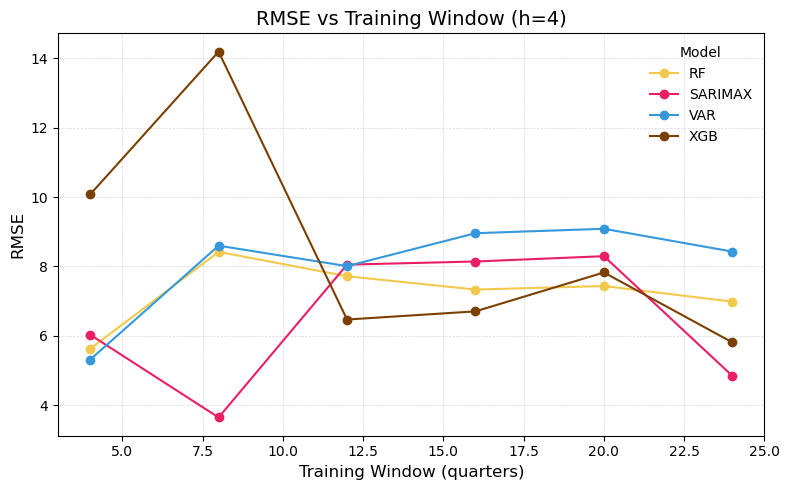

,train_quarters,Model,RMSE,MAE
0,4,SARIMAX,6.030018,5.583333
1,4,VAR,5.309709,3.840950
2,4,RF,5.623638,5.075000
3,4,XGB,10.074197,7.999885
4,8,SARIMAX,3.644405,3.265416
5,8,VAR,8.597444,6.609711
6,8,RF,8.419286,7.957500
7,8,XGB,14.194238,11.499388
8,12,SARIMAX,8.051280,6.994308
9,12,VAR,8.007986,7.791945


In [35]:
compare_multivariate_static_windows(
    df=state_bees,
    date_col='date',
    target_col='percent_lost',
    exog_cols=['varroa_mites','other_pests_and_parasites','diseases','pesticides','other_or_unknown'],
    windows=[4,8,12,16,20,24],
    forecast_horizon=4,
    seasonal_m=4,
    lags=[1,4]
)

<div
  style="
    background-color: #fffad5;
    color: black;
    font-weight: bold;
    height: 50px;
    line-height: 50px;
    border-radius: 5px;
    padding: 0 10px;
  "
>
  <h7 style="margin: 0; display: inline-block; vertical-align: middle;">
    Walk-forward method for multivariate analysis
  </h7>
</div>

In [29]:
def compare_multivariate_walkforward(
    df: pd.DataFrame,
    date_col: str,
    target_col: str,
    exog_cols: list[str],
    n_test: int = 8,
    seasonal_m: int = 4,
    lags: list[int] = [1, 4]
) -> pd.DataFrame:
    # --- Prepare data ---
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df.set_index(date_col, inplace=True)
    df.sort_index(inplace=True)

    train_df = df.iloc[:-n_test]
    test_df  = df.iloc[-n_test:]
    history  = train_df.copy()
    idx_test = test_df.index

    preds = { 'ARIMAX': [], 'VAR': [], 'RF (lags)': [], 'XGB (lags)': [] }

    for t in range(n_test):
        # 1) ARIMAX
        y_hist  = history[target_col]
        ex_hist = history[exog_cols]
        m_ari   = auto_arima(y_hist, exogenous=ex_hist,
                             seasonal=True, m=seasonal_m,
                             stepwise=True, trace=False,
                             error_action='ignore')
        ex_next = test_df[exog_cols].iloc[[t]]
        preds['ARIMAX'].append(
            np.asarray(m_ari.predict(1, exogenous=ex_next)).ravel()[0]
        )

        # 2) VAR
        df_var = history[[target_col]+exog_cols]
        var_m  = VAR(df_var)
        k, N   = df_var.shape[1], df_var.shape[0]
        try:
            var_f = var_m.fit(ic='aic', maxlags=seasonal_m)
        except ValueError:
            safe = max(1, N//(k*5))
            var_f = var_m.fit(maxlags=safe)
        fc_var = var_f.forecast(df_var.values[-var_f.k_ar:], steps=1)[0]
        idx_tar = df_var.columns.get_loc(target_col)
        preds['VAR'].append(fc_var[idx_tar])

        # 3+4) ML on lags
        df_ml = history[[target_col]+exog_cols].copy()
        for col in [target_col]+exog_cols:
            for lag in lags:
                df_ml[f'{col}_lag_{lag}'] = df_ml[col].shift(lag)
        df_ml.dropna(inplace=True)
        X_ml, y_ml = df_ml.drop(columns=[target_col]), df_ml[target_col]

        # build next‐step features: contemporaneous exogs + all lags
        feat = {col: test_df[col].iloc[t] for col in exog_cols}
        for col in [target_col]+exog_cols:
            for lag in lags:
                feat[f'{col}_lag_{lag}'] = history[col].iloc[-lag]

        # RandomForest
        rf = RandomForestRegressor(n_estimators=100, random_state=42)
        rf.fit(X_ml, y_ml)
        preds['RF (lags)'].append(rf.predict(pd.DataFrame([feat]))[0])

        # XGBoost
        xgb = XGBRegressor(n_estimators=100, random_state=42,
                           use_label_encoder=False, eval_metric='rmse')
        xgb.fit(X_ml, y_ml)
        preds['XGB (lags)'].append(xgb.predict(pd.DataFrame([feat]))[0])

        # reveal next actual
        history = pd.concat([history, test_df.iloc[[t]]])

    # --- Build Series & compute overall metrics ---
    s_true = test_df[target_col]
    s_pred = {name: pd.Series(vals, index=idx_test, name=name)
              for name, vals in preds.items()}

    def score(y_t, y_p):
        m = (~y_t.isna()) & (~y_p.isna())
        if not m.any():
            return np.nan, np.nan
        return (np.sqrt(mean_squared_error(y_t[m], y_p[m])),
                mean_absolute_error(y_t[m], y_p[m]))

    metrics = pd.DataFrame([
        (name, *score(s_true, s_pred[name]))
        for name in s_pred
    ], columns=['Model','RMSE','MAE'])

    # --- Plot 1: forecasts vs. actual with quarterly x‐tick formatting ---
    df_plot = pd.concat([s_true.rename('Actual'), *s_pred.values()], axis=1)

    fig, ax = plt.subplots(figsize=(12, 4))
    df_plot.plot(marker='o', ax=ax)

    # Mark the start of the test period
    ax.axvline(idx_test[0], color='gray', linestyle='--', label='Start Test')

    # Titles and labels
    ax.set_title('One-Step Walk-Forward Forecasts vs Actual')
    ax.set_xlabel('Date')
    ax.set_ylabel(target_col)

    # Format x-axis ticks as "YYYYQ#"
    quarters = [f"{d.year}Q{d.quarter}" for d in df_plot.index]
    ax.set_xticks(df_plot.index)
    ax.set_xticklabels(quarters, rotation=90, ha='center', fontsize=8)


    # --- Plot 2: cumulative RMSE & MAE by quarter ---
    errors = {name: s_pred[name].values - s_true.values
              for name in s_pred}
    ks = np.arange(1, n_test+1)
    cum_rmse = pd.DataFrame({name: [
        np.sqrt((errors[name][:k]**2).mean()) for k in ks
    ] for name in errors}, index=idx_test)
    cum_mae  = pd.DataFrame({name: [
        np.abs(errors[name][:k]).mean() for k in ks
    ] for name in errors}, index=idx_test)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4), sharex=True)

    # Plot RMSE
    cum_rmse.plot(ax=ax1, marker='o')
    ax1.set_title('RMSE by Predicted Quarter')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('RMSE')
    
    # Plot MAE
    cum_mae.plot(ax=ax2, marker='o')
    ax2.set_title('MAE by Predicted Quarter')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('MAE')
    
    # Format x-axis ticks as "YYYYQ#"
    quarters = [f"{d.year}Q{d.quarter}" for d in cum_rmse.index]
    for ax in (ax1, ax2):
        ax.set_xticks(cum_rmse.index)
        ax.set_xticklabels(quarters, rotation=90, ha='center', fontsize=8)
    
    plt.tight_layout()
    plt.show()

    return metrics


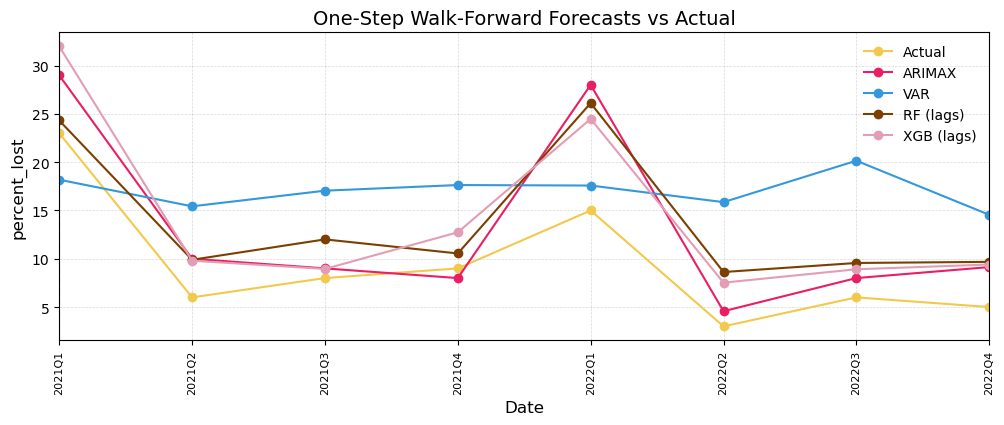

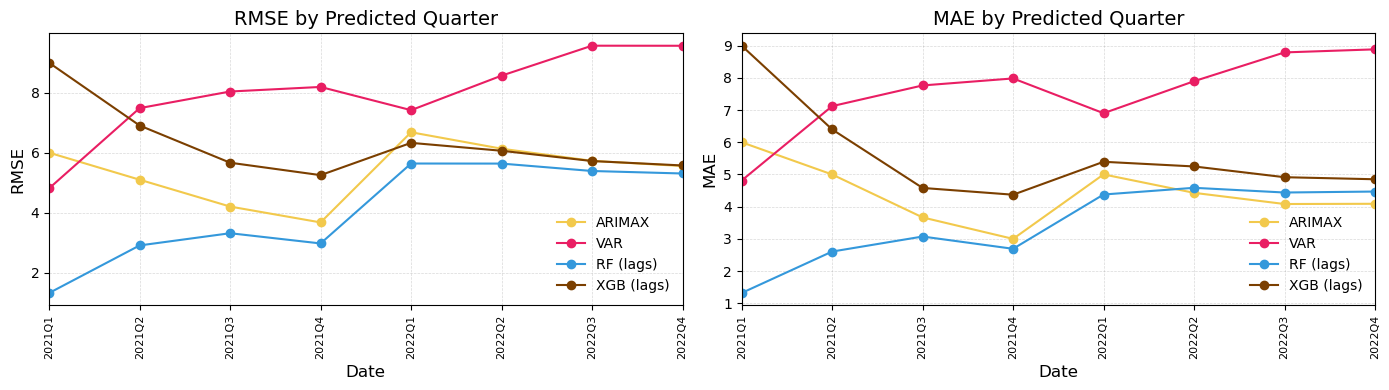

,Model,RMSE,MAE
0,ARIMAX,5.554806,4.089583
1,VAR,9.567674,8.885230
2,RF (lags),5.306259,4.469730
3,XGB (lags),5.574291,4.851121


In [ ]:
compare_multivariate_walkforward(
    df=state_bees,
    date_col='date',
    target_col='percent_lost',
    exog_cols=[
        'varroa_mites', 'other_pests_and_parasites', 'diseases', 'pesticides',
        'other_or_unknown'
    ],  # adjust features of interest as needed
    n_test=8,
    seasonal_m=4,
    lags=[1, 4]
)

<div
  style="
    background-color: #985b10;
    color: white;
    font-weight: bold;
    height: 50px;
    line-height: 50px;
    border-radius: 5px;
    padding: 0 10px;
  "
>
  <h5 style="margin: 0; display: inline-block; vertical-align: middle;">
    Multiple states example for a particular prediction
  </h5>
</div>

Results for California


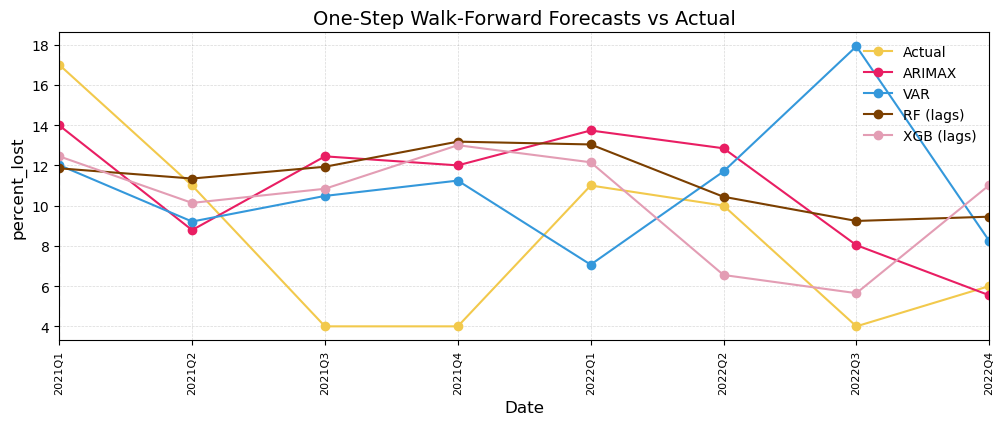

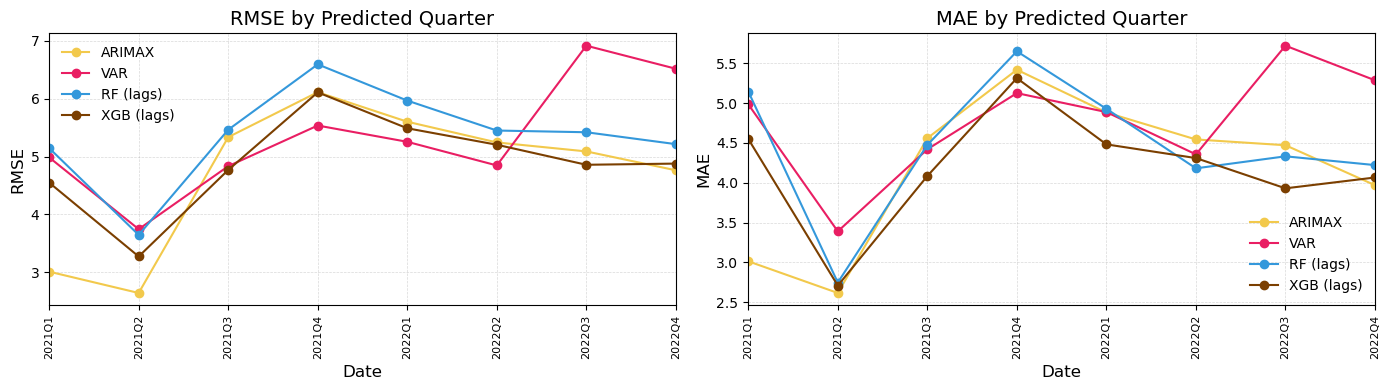


========== California ==========
        Model      RMSE       MAE
0      ARIMAX  4.762549  3.968846
1         VAR  6.515409  5.287100
2   RF (lags)  5.213981  4.221507
3  XGB (lags)  4.878266  4.065634


Results for Texas


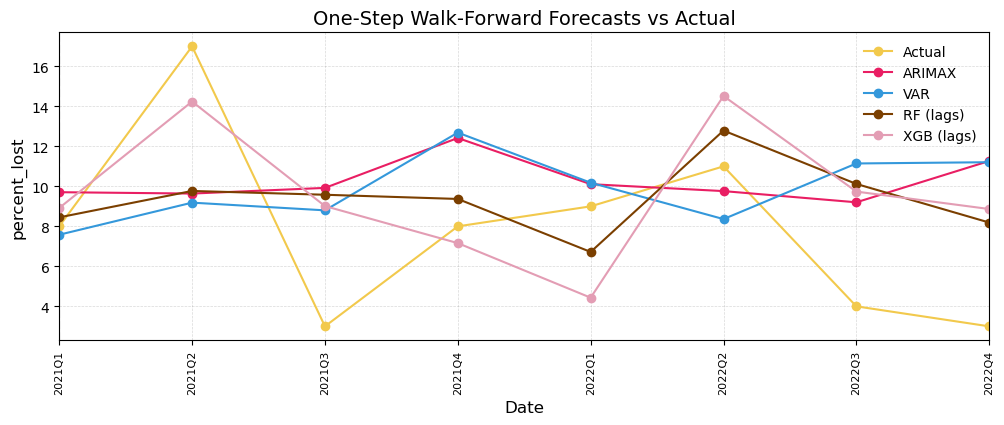

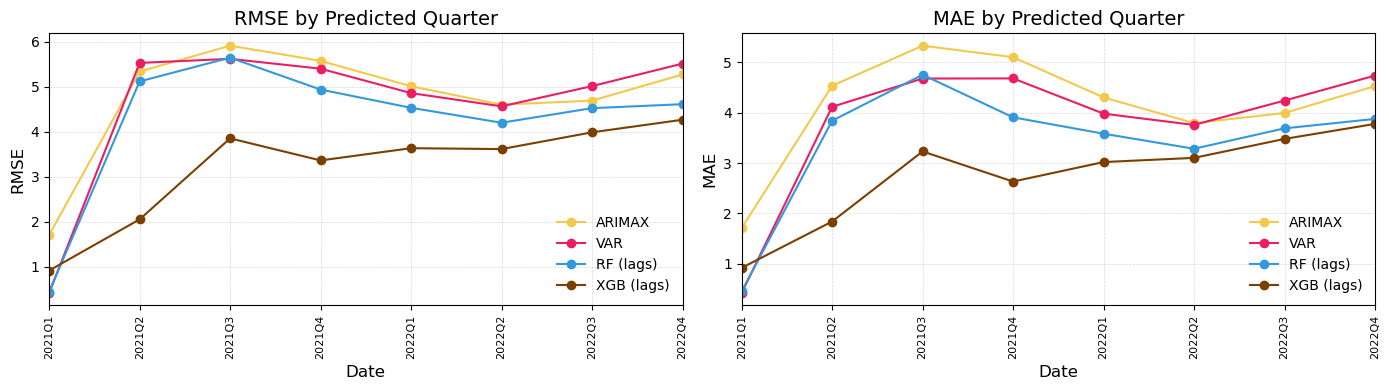


========== Texas ==========
        Model      RMSE       MAE
0      ARIMAX  5.276252  4.528070
1         VAR  5.518123  4.736332
2   RF (lags)  4.615831  3.876202
3  XGB (lags)  4.270315  3.777234


Results for Florida


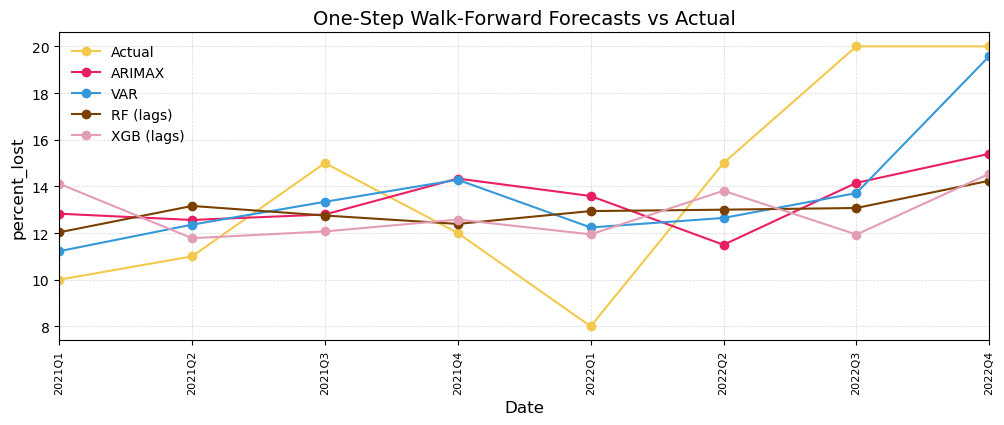

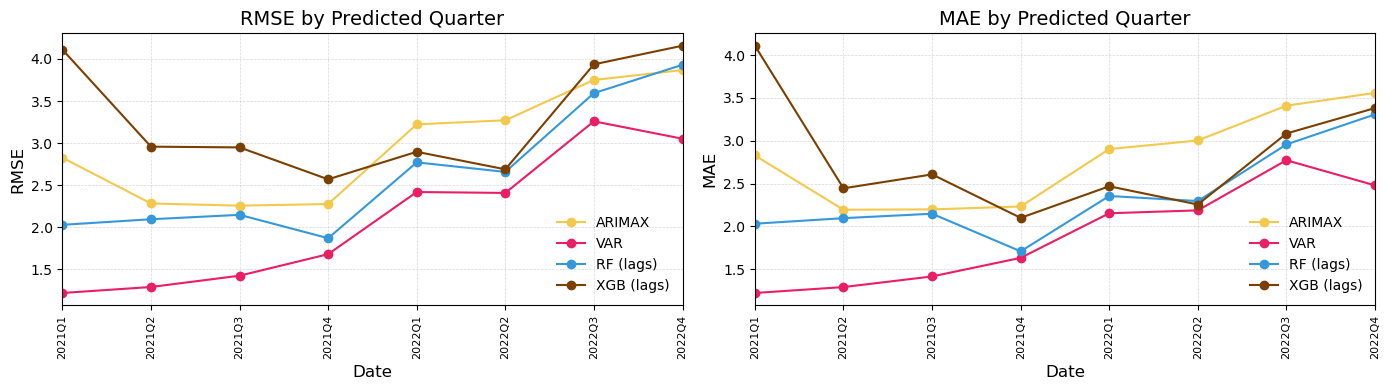


========== Florida ==========
        Model      RMSE       MAE
0      ARIMAX  3.867449  3.559077
1         VAR  3.052402  2.478285
2   RF (lags)  3.930282  3.307227
3  XGB (lags)  4.157160  3.381605



Overall Summary
         Model      RMSE       MAE       state
0       ARIMAX  4.762549  3.968846  California
1          VAR  6.515409  5.287100  California
2    RF (lags)  5.213981  4.221507  California
3   XGB (lags)  4.878266  4.065634  California
4       ARIMAX  5.276252  4.528070       Texas
5          VAR  5.518123  4.736332       Texas
6    RF (lags)  4.615831  3.876202       Texas
7   XGB (lags)  4.270315  3.777234       Texas
8       ARIMAX  3.867449  3.559077     Florida
9          VAR  3.052402  2.478285     Florida
10   RF (lags)  3.930282  3.307227     Florida
11  XGB (lags)  4.157160  3.381605     Florida


In [ ]:
states = ['California', 'Texas', 'Florida'] # input states of interest to run (more states means longer run time)
function_to_run = compare_multivariate_walkforward # input model of interest

n_test = 8
lags   = [1, 4]

all_metrics = []
for st in states:
    print(f'Results for {st}')
    # Filter from the full bees DataFrame
    df_st = bees[bees['state'] == st].copy()
    
    # Make sure there’s enough historical data
    total_q   = len(df_st)
    min_needed = n_test + max(lags) + 1
    if total_q < min_needed:
        print(f"Skipping {st}: only {total_q} quarters (need ≥ {min_needed})")
        continue
    
    try:
        metrics = function_to_run(
            df         = df_st,
            date_col   = 'date',
            target_col = 'percent_lost',
            exog_cols  = [
                'varroa_mites',
                'other_pests_and_parasites',
                'diseases',
                'pesticides',
                'other_or_unknown'
            ],
            n_test     = n_test,
            seasonal_m = 4,
            lags       = lags
        )
    except ValueError as e:
        print(f"Error for {st}: {e}")
        continue

    # Print a header for this state, then its metrics
    print("\n" + "="*10 + f" {st} " + "="*10)
    print(metrics)
    print("\n" + "="*130)
    print("\n" + "="*130)
    # keep for later aggregation if you want
    metrics = metrics.copy()
    metrics['state'] = st
    all_metrics.append(metrics)


if all_metrics:
    summary = pd.concat(all_metrics, ignore_index=True)
    print("\n" + "="*30)
    print("Overall Summary")
    print("="*30)
    print(summary)